# Импорт библиотек

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset, random_split, Dataset
#from google.colab import drive
import os
from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

#from google.colab import drive
#drive.mount('/content/drive') /kaggle/working/cropped_image_1.jpg

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Загрузка изображениий

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Трансформации для контентных изображений
content_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

content_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Трансформации для стилевых изображений (если требуется)
style_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Применение трансформаций к изображению
transformKet = transforms.Compose([
    transforms.Resize((256, 256)),  # Заменяем CenterCrop на Resize
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Трансформации для аугментации данных
augmentation_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Класс Dataset для основных фотографий
class ContentDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Класс Dataset для фотографий со стилем
class StyleDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

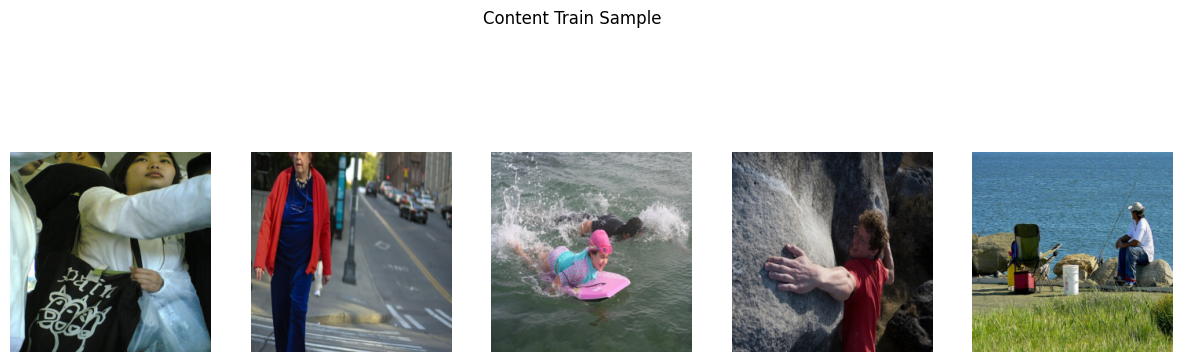

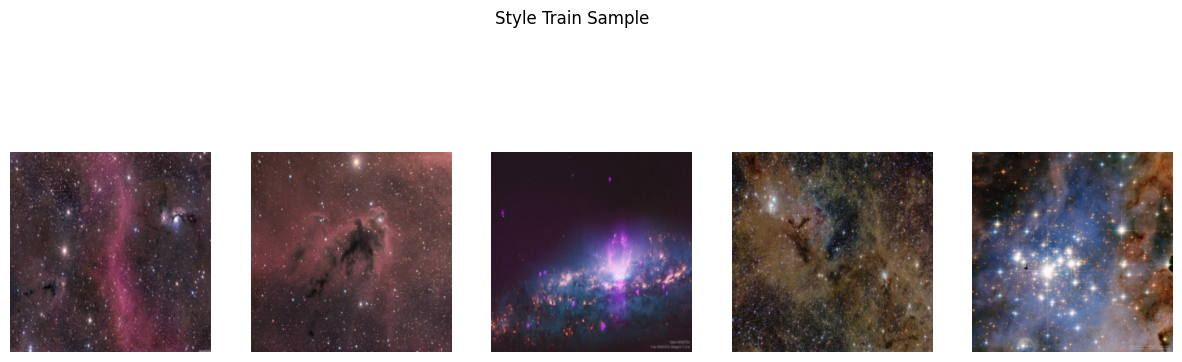

In [ ]:
# Функция для отмены нормализации
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Вывод изображений на экран
def show_images(images, title=None):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        img = unnormalize(img, mean, std)  # Отмена нормализации
        img = img.clamp(0, 1)  # Ограничение значений пикселей в диапазоне [0, 1]
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].axis('off')
    if title:
        fig.suptitle(title)
    plt.show()

# Вывод по 5 изображений из каждой группы
content_train_sample = [content_test_dataset[i] for i in random.sample(range(len(content_test_dataset)), 5)]
#content_test_sample = [content_test_dataset[i] for i in random.sample(range(len(content_test_dataset)), 5)]
style_train_sample = [style_train_dataset[i] for i in random.sample(range(len(style_train_dataset)), 5)]
#style_test_sample = [style_test_dataset[i] for i in random.sample(range(len(style_test_dataset)), 5)]

# Отображение изображений
show_images(content_train_sample, title='Content Train Sample')
#show_images(content_test_sample, title='Content Test Sample')
show_images(style_train_sample, title='Style Train Sample')
#show_images(style_test_sample, title='Style Test Sample')

## Построения модели

In [ ]:

# Генератор CycleGAN
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        super(Generator, self).__init__()
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
                 nn.InstanceNorm2d(ngf),
                 nn.LeakyReLU(0.2, True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.LeakyReLU(0.2, True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.LeakyReLU(0.2, True)]

        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

# Резидуальный блок для генератора
class ResBlock(nn.Module):
    def __init__(self, dim):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.LeakyReLU(0.2, True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

# Дискриминатор CycleGAN
class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(Discriminator, self).__init__()
        model = [nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
                 nn.LeakyReLU(0.2, True)]

        for i in range(1, n_layers):
            mult = 2**(i-1)
            model += [nn.Conv2d(ndf * mult, ndf * mult * 2, kernel_size=4, stride=2, padding=1),
                      nn.InstanceNorm2d(ndf * mult * 2),
                      nn.LeakyReLU(0.2, True)]

        mult = 2**(n_layers-1)
        model += [nn.Conv2d(ndf * mult, ndf * mult * 2, kernel_size=4, stride=1, padding=1),
                  nn.InstanceNorm2d(ndf * mult * 2),
                  nn.LeakyReLU(0.2, True)]

        model += [nn.Conv2d(ndf * mult * 2, 1, kernel_size=4, stride=1, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

In [ ]:
selected_layers_style = [ '1', '5',  '10', '14', '19', '22','25', '28', '32' ] # Слои для извличения
selected_layers_content=[ '21']

# Загрузка предварительно обученной VGG16 модели для perceptual loss
vgg = models.vgg19(pretrained=True).features
vgg.eval()
for param in vgg.parameters():
    param.requires_grad = False

class StyleLoss(nn.Module):
    def __init__(self, vgg, selected_layers_style):
        super(StyleLoss, self).__init__()
        self.vgg = vgg
        self.criterion = nn.MSELoss()

    def gram_matrix(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)  # Добавляем размерность пакета
        b, c, h, w = x.size()
        features = x.view(b * c, h * w)
        G = torch.mm(features, features.t())
        return G.div(b * c * h * w)

    def forward(self, x, y):
        loss = 0.0
        for layer in selected_layers_style:
            x_vgg = x
            y_vgg = y
            for i in range(int(layer) + 1):
                x_vgg = self.vgg[i](x_vgg)
                y_vgg = self.vgg[i](y_vgg)
            G_x = self.gram_matrix(x_vgg)
            G_y = self.gram_matrix(y_vgg)
            loss += self.criterion(G_x, G_y)
        return loss

class ContentLoss(nn.Module):
    def __init__(self, vgg, selected_layers_content):
        super(ContentLoss, self).__init__()
        self.vgg = vgg
        self.criterion = nn.MSELoss()
        self.selected_layers = selected_layers_content

    def forward(self, x, y):
        loss = 0.0
        for layer in self.selected_layers:
            x_vgg = x
            y_vgg = y
            for i in range(int(layer) + 1):
                x_vgg = self.vgg[i](x_vgg)
                y_vgg = self.vgg[i](y_vgg)
            loss += self.criterion(x_vgg, y_vgg)
        return loss

StyleLoss = StyleLoss(vgg, selected_layers_style).to(device)
content_loss = ContentLoss(vgg, selected_layers_content ).to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 157MB/s]  


In [ ]:
# Функция для инициализации весов
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Определите обратные преобразования для отмены нормализации
def inv_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

# Функция для отображения изображений
def imshow_tensor(tensor, title=None):
    image = tensor.cpu().clone()  # клонируем тензор, чтобы не изменять оригинал
    if len(image.shape) == 4 and image.shape[0] == 1:
        image = image.squeeze(0)  # удаляем лишнюю размерность, если она существует и тензор имеет 4 размерности
    image = inv_normalize(image)  # отменяем нормализацию
    image = image.detach().numpy() # отсоединяем тензор и преобразуем в numpy массив
    image = image.transpose((1, 2, 0))  # меняем оси для отображения
    image = np.clip(image, 0, 1)  # обрезаем значения, чтобы они были в диапазоне [0, 1]
    return image

In [ ]:
# Параметры
input_nc = 3  # Количество входных каналов
output_nc = 3  # Количество выходных каналов
ngf = 64  # Количество фильтров в генераторе
ndf = 64  # Количество фильтров в дискриминаторе
n_blocks = 12  # Количество резидуальных блоков в генераторе
n_layers_D = 3  # Количество слоев в дискриминаторе
lr = 0.0001  # Скорость обучения
beta1 = 0.1  # Параметр beta1 для оптимизатора Adam


# Инициализация моделей
G_AB = Generator(input_nc, output_nc, ngf, n_blocks).apply(weights_init).to(device)
G_BA = Generator(input_nc, output_nc, ngf, n_blocks).apply(weights_init).to(device)
D_A = Discriminator(input_nc, ndf, n_layers_D).apply(weights_init).to(device)
D_B = Discriminator(input_nc, ndf, n_layers_D).apply(weights_init).to(device)

# Оптимизаторы
optimizer_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

# Функции потерь
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()
#https://github.com/avinash-mishra/gan-style-transfer/blob/master/msgnet.ipynb


In [ ]:
# Загрузка состояния модели G_AB и перевод модели на указанное устройство
G_AB.load_state_dict(torch.load('/kaggle/input/model1-1/G_AB96.pth', map_location=device))
G_AB.to(device)

# Загрузка состояния модели G_BA и перевод модели на указанное устройство
G_BA.load_state_dict(torch.load('/kaggle/input/model1-1/G_AB96.pth', map_location=device))
G_BA.to(device)

# Загрузка состояния модели D_A и перевод модели на указанное устройство
D_A.load_state_dict(torch.load('/kaggle/input/model1-1/D_A.pth', map_location=device))
D_A.to(device)

# Загрузка состояния модели D_B и перевод модели на указанное устройство
D_B.load_state_dict(torch.load('/kaggle/input/model1-1/D_B.pth', map_location=device))
D_B.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] Loss_G: 13.3269 Loss_D_A: 0.3187 Loss_D_B: 0.2983


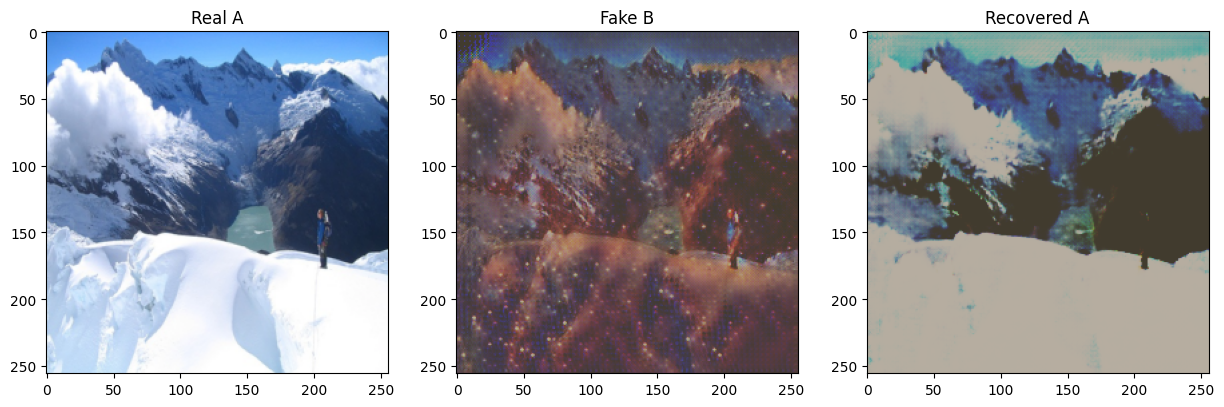

Epoch [2/10] Loss_G: 16.4587 Loss_D_A: 0.3187 Loss_D_B: 0.2983


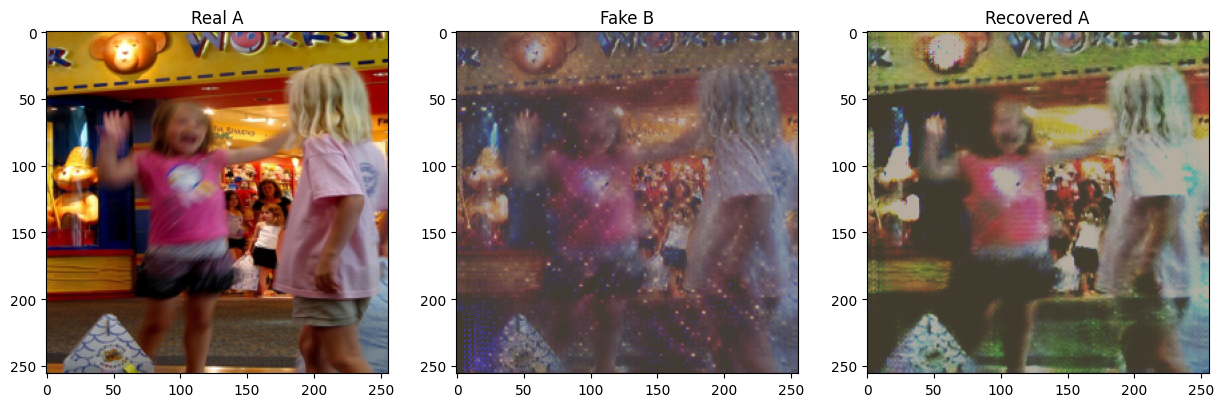

Epoch [3/10] Loss_G: 18.1307 Loss_D_A: 1.0558 Loss_D_B: 0.4781


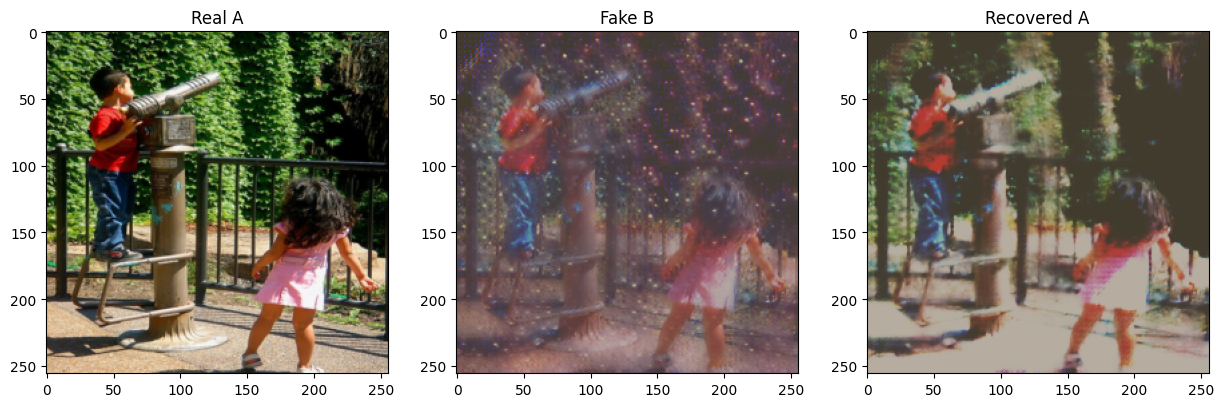

Epoch [4/10] Loss_G: 21.8222 Loss_D_A: 1.0558 Loss_D_B: 0.4781


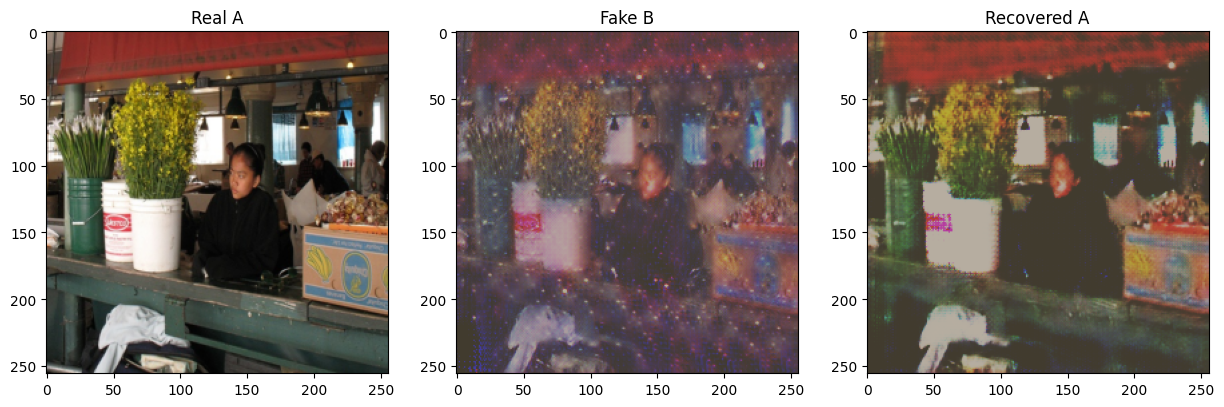

Epoch [5/10] Loss_G: 18.3378 Loss_D_A: 0.4458 Loss_D_B: 5.1475


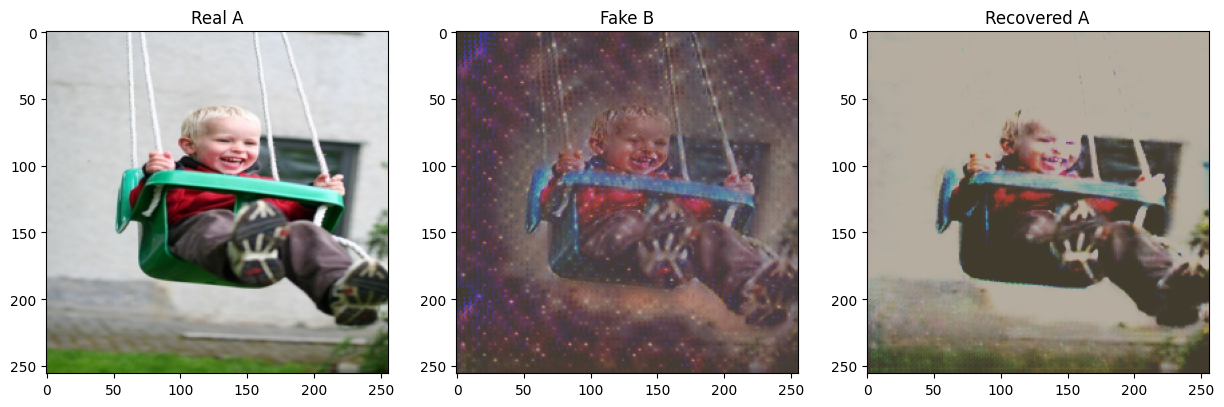

Epoch [6/10] Loss_G: 15.4649 Loss_D_A: 0.4458 Loss_D_B: 5.1475


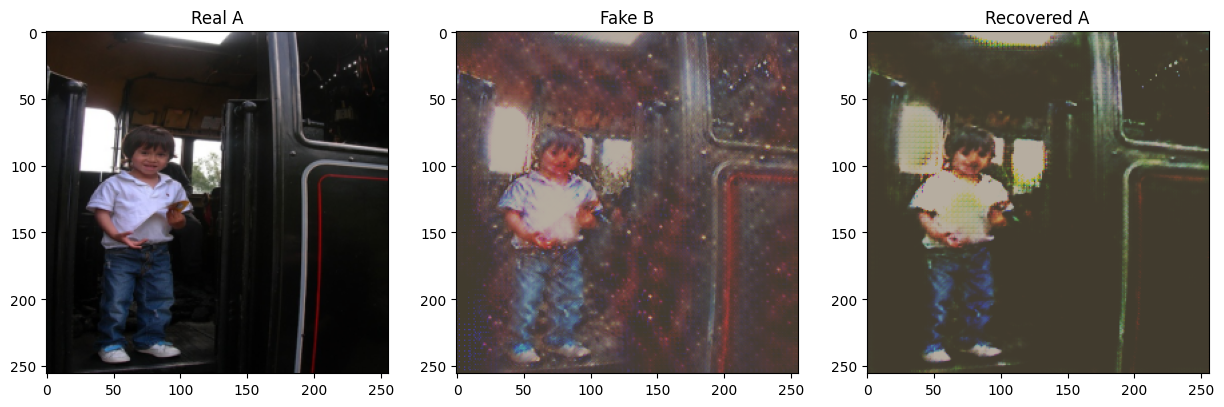

Epoch [7/10] Loss_G: 19.9241 Loss_D_A: 0.7252 Loss_D_B: 1.4551


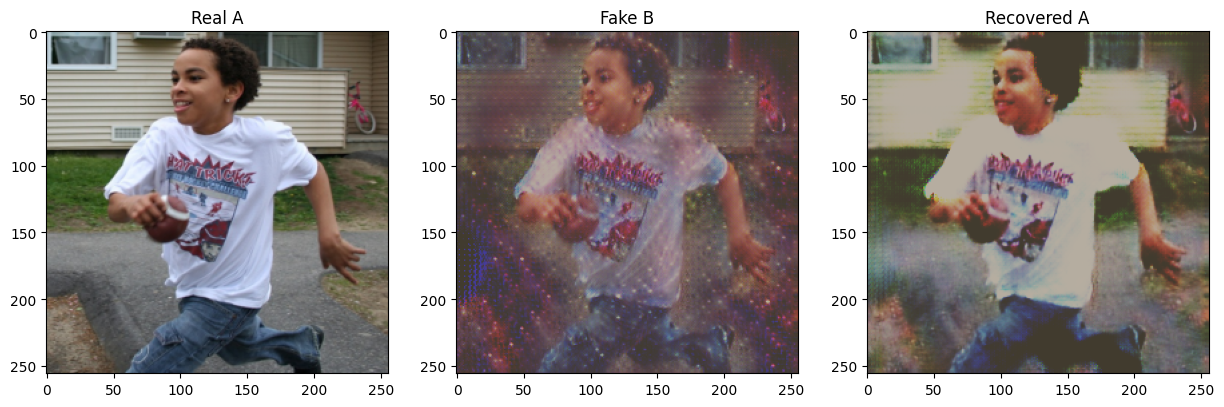

Epoch [8/10] Loss_G: 17.0816 Loss_D_A: 0.7252 Loss_D_B: 1.4551


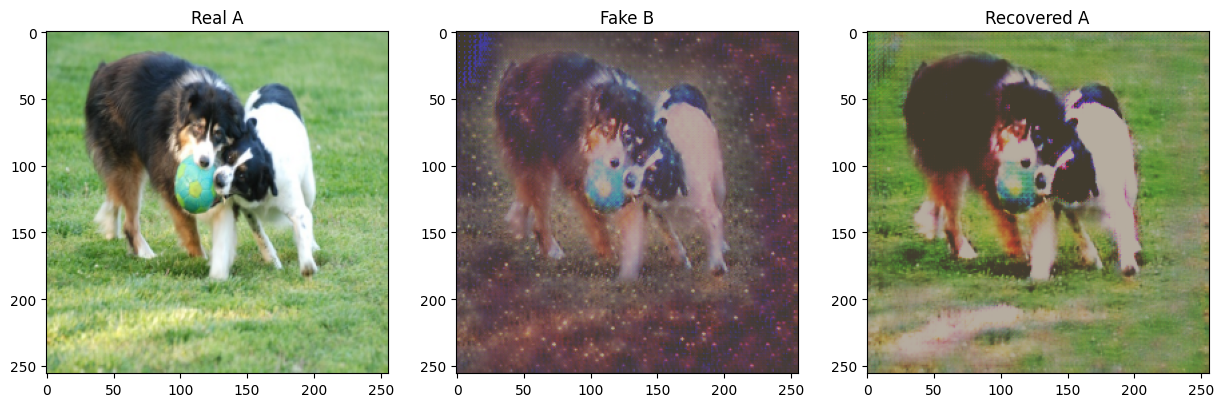

Epoch [9/10] Loss_G: 21.7202 Loss_D_A: 0.7007 Loss_D_B: 0.4111


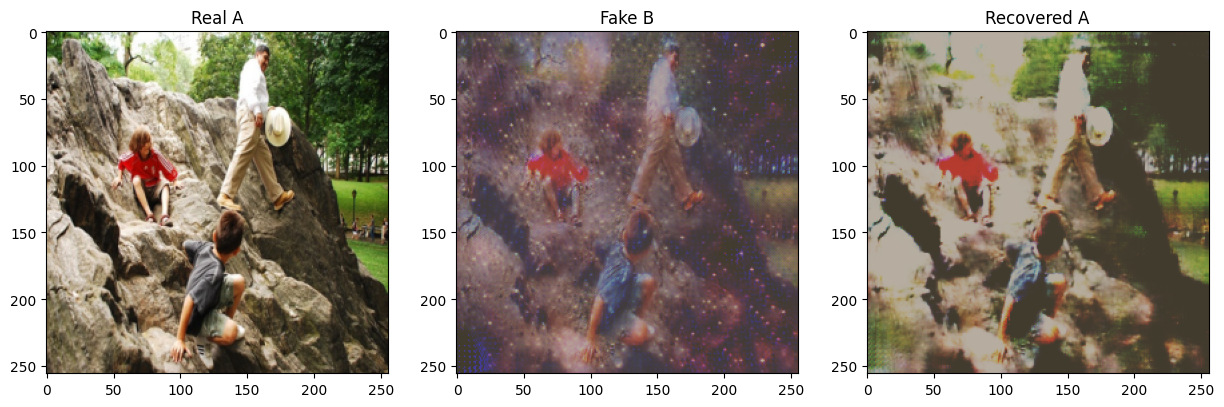

Epoch [10/10] Loss_G: 16.2450 Loss_D_A: 0.7007 Loss_D_B: 0.4111


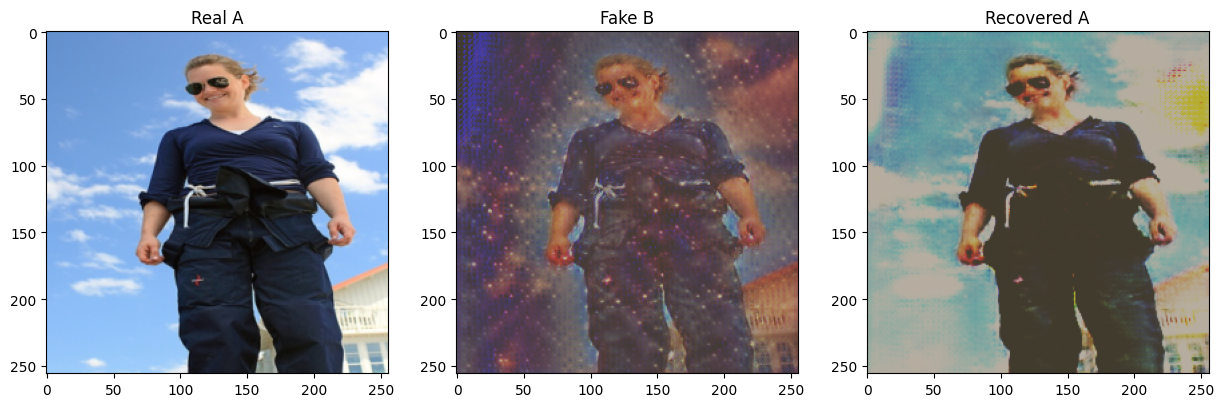

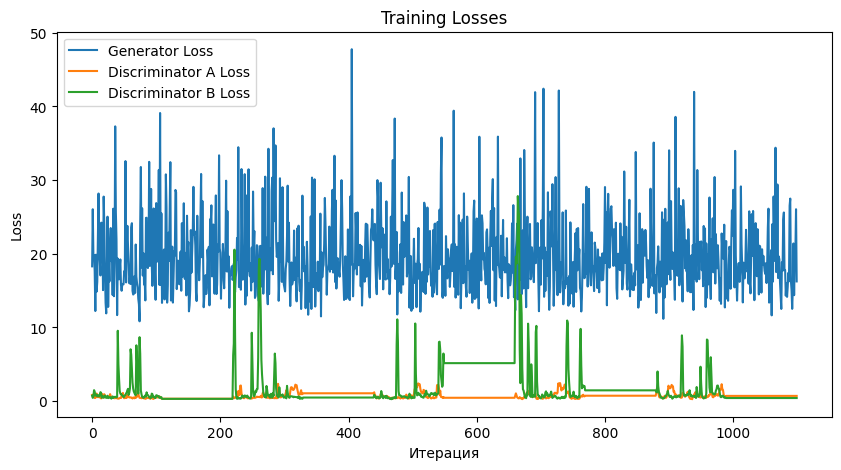

In [ ]:
# Инициализация списков для хранения потерь
loss_G_list = []
loss_D_A_list = []
loss_D_B_list = []

num_epochs = 10  # Количество эпох обучения
lambda_cyc = 2 # Вес для потерь циклической согласованности
lambda_id = 0.5# Вес для потерь идентичности
style_weight = 17000.0  # Вес для Style Loss

# Увеличение весов для функций потерь дискриминатора
lambda_D_A = 80
lambda_D_B = 70
for epoch in tqdm(range(num_epochs)):
    for real_images, style_images in zip(content_train_dataloader, style_train_dataloader):
        real_A = real_images.to(device)
        real_B = style_images.to(device)

        # Генерация изображений
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        # Циклическая согласованность
        rec_A = G_BA(fake_B)
        rec_B = G_AB(fake_A)

        # Идентичность
        id_A = G_BA(real_A)
        id_B = G_AB(real_B)

        # Потери генератора
        loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))
        loss_cycle_A = criterion_cycle(rec_A, real_A) * lambda_cyc
        loss_cycle_B = criterion_cycle(rec_B, real_B) * lambda_cyc
        loss_identity_A = criterion_identity(id_A, real_A) * lambda_id
        loss_identity_B = criterion_identity(id_B, real_B) * lambda_id
        loss_G_content = content_loss(fake_B, real_A) * 0.04
        loss_G_style = StyleLoss(fake_B, real_B) * style_weight

        loss_G = loss_GAN_AB + loss_GAN_BA + loss_cycle_A + loss_cycle_B + loss_identity_A + loss_identity_B + loss_G_content +  loss_G_style

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Потери дискриминатора A
        if epoch % 2 == 0:
            loss_D_A_real = criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A)))
            loss_D_A_fake = criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A.detach())))
            loss_D_A = (loss_D_A_real + loss_D_A_fake) * lambda_D_A

            optimizer_D_A.zero_grad()
            loss_D_A.backward()
            optimizer_D_A.step()

        # Потери дискриминатора B
        if epoch % 2 == 0:
            loss_D_B_real = criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B)))
            loss_D_B_fake = criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B.detach())))
            loss_D_B = (loss_D_B_real + loss_D_B_fake) * lambda_D_B

            optimizer_D_B.zero_grad()
            loss_D_B.backward()
            optimizer_D_B.step()

        # Сохранение потерь
        loss_G_list.append(loss_G.item())
        loss_D_A_list.append(loss_D_A.item())
        loss_D_B_list.append(loss_D_B.item())

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss_G: {loss_G.item():.4f} Loss_D_A: {loss_D_A.item():.4f} Loss_D_B: {loss_D_B.item():.4f}')

    # Вывод изображений после каждой эпохи
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(imshow_tensor(real_A[0]))
    axes[0].set_title('Real A')
    axes[1].imshow(imshow_tensor(fake_B[0]))
    axes[1].set_title('Fake B')
    axes[2].imshow(imshow_tensor(rec_A[0]))
    axes[2].set_title('Recovered A')
    plt.show()

# Построение графика потерь после последней эпохи
plt.figure(figsize=(10, 5))
plt.plot(loss_G_list, label='Generator Loss')
plt.plot(loss_D_A_list, label='Discriminator A Loss')
plt.plot(loss_D_B_list, label='Discriminator B Loss')
plt.xlabel('Итерация')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()

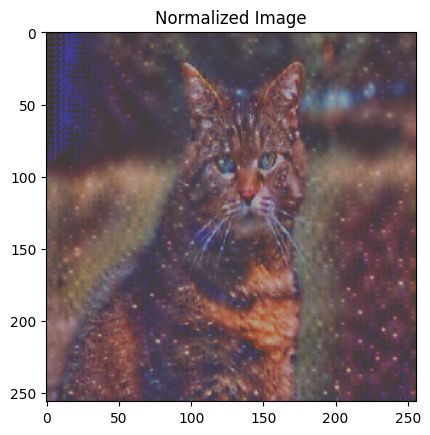

In [ ]:
# Загрузка изображения
image = Image.open('/kaggle/input/osmoat/1638838314_13-koshka-top-p-realnie-kotov-17.jpg')

# Применение трансформаций
normalized_image = transformKet(image)

# Добавление размерности batch
#normalized_image = normalized_image.unsqueeze(0)

# Преобразование стиля
with torch.no_grad():
    fake_B = G_AB(normalized_image.to(device))

#  id_A = G_BA(real_A)
#  id_B = G_AB(real_B)
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # клонируем тензор, чтобы не изменять оригинал
    image = image.squeeze(0)      # удаляем лишнюю размерность
    image = inv_normalize(image)  # отменяем нормализацию
    image = image.detach().numpy() # отсоединяем тензор и преобразуем в numpy массив
    image = image.transpose((1, 2, 0))  # меняем оси для отображения
    image = np.clip(image, 0, 1)  # обрезаем значения, чтобы они были в диапазоне [0, 1]
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)  # немного подождём, чтобы обновить изображение

# Отображение изображения
imshow(fake_B, title='Normalized Image')
plt.show()

In [ ]:
# Сохранение моделей
torch.save(G_AB.state_dict(), 'G_AB.pth')
torch.save(G_BA.state_dict(), 'G_BA.pth')
torch.save(D_A.state_dict(), 'D_A.pth')
torch.save(D_B.state_dict(), 'D_B.pth')